In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('mode.chained_assignment', None)

In [3]:
%cd '/Users/nicholassanso/Desktop/GA/projects/project-3'

/Users/nicholassanso/Desktop/GA/projects/project-3


<font size="8">Importing Data and Preprocessing</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)

In [4]:
data_types = ['investing', 'stocks']
dataframes = {data_type: [] for data_type in data_types}

for data_type in data_types:
    for i in range(1, 23):
        filename = f'./data/{data_type}_{i}.csv'
        df = pd.read_csv(filename)
        dataframes[data_type].append(df)

df_investing = pd.concat(dataframes['investing'], axis=0, ignore_index=True)
df_stocks = pd.concat(dataframes['stocks'], axis=0, ignore_index=True)

In [5]:
df_investing = df_investing.drop_duplicates(subset=['name'])
df_stocks = df_stocks.drop_duplicates(subset=['name'])

print(df_stocks.shape)
print(df_investing.shape)

(1993, 33)
(2509, 33)


In [6]:
#balance the classes
df_stocks_upsampled = resample(df_stocks, 
                               replace=True, 
                               n_samples=len(df_investing),    
                               random_state=42)

#combine majority class with upsampled minority class
df_combined = pd.concat([df_investing, df_stocks_upsampled])

print(df_combined['subreddit'].value_counts())

investing    2509
stocks       2509
Name: subreddit, dtype: int64


In [7]:
null_counts = df_stocks_upsampled.isnull().sum()
print(null_counts[null_counts > 0])

category          2509
likes             2509
suggested_sort    1153
banned_at_utc     2509
view_count        2509
num_reports       2509
media             2509
id                2507
name                 2
dtype: int64


In [8]:
null_counts = df_investing.isnull().sum()
print(null_counts[null_counts > 0])

category          2509
likes             2509
suggested_sort    2400
banned_at_utc     2509
view_count        2509
num_reports       2509
media             2509
id                2508
name                 1
dtype: int64


<font size="6">Preprocessing</font>


In [9]:
df_stocks = df_stocks.dropna(subset=['name'])
df_investing = df_investing.dropna(subset=['name'])

In [10]:
df_combined = pd.concat([df_investing,df_stocks], axis=0, ignore_index=True)

In [11]:
df_combined.drop('Unnamed: 0', axis=1, inplace= True)

In [12]:
def count_indep_clauses(text):
    #define the regular expression pattern
    pattern = r',\s*(for|and|nor|but|or|yet)\s'
    
    #find all matches in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    #return the count of matches
    return len(matches)

In [13]:
def count_indep_and_dep_clauses(text):
    #count the number of commas in the text
    num_commas = text.count(',')
    
    #return the count
    return num_commas

In [14]:
df_combined['indep_clauses_count_selftext'] = df_combined['selftext'].apply(count_indep_clauses)
df_combined['indep_and_dep_clauses_count_selftext'] = df_combined['selftext'].apply(count_indep_and_dep_clauses)

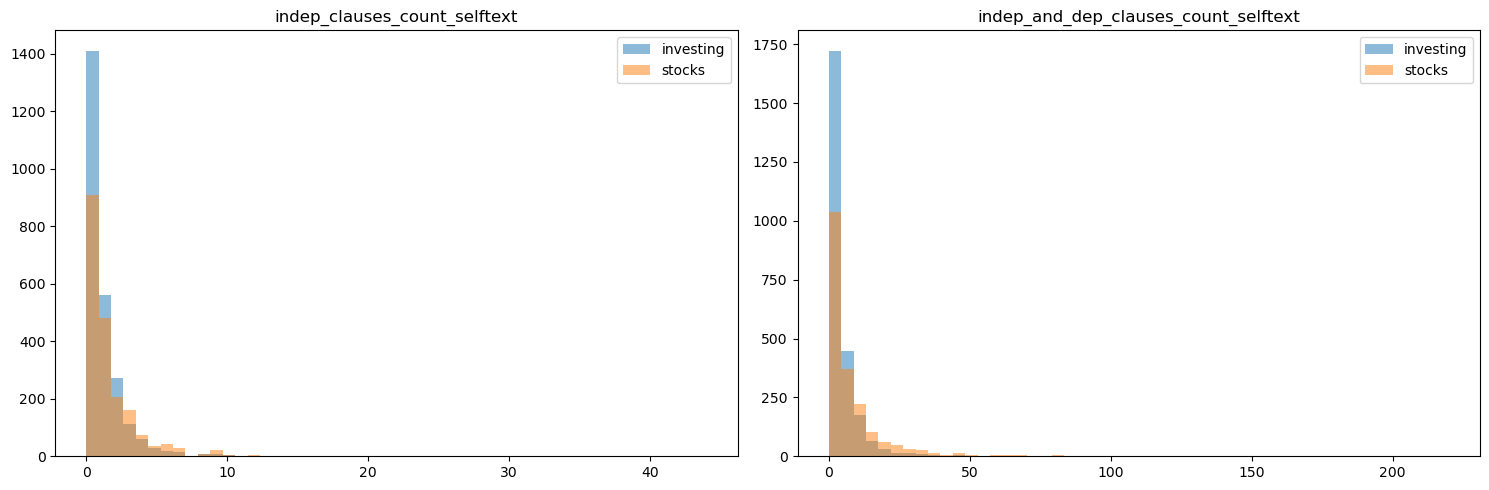

In [15]:
# define the columns for which to create histograms
columns = ['indep_clauses_count_selftext', 'indep_and_dep_clauses_count_selftext']

# get the unique values of the subreddit column
subreddits = df_combined['subreddit'].unique()

# create a figure with multiple subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))  

# iterate over the columns and create overlaid histograms for each column
for i, col in enumerate(columns):
    # calculate the bin edges for the current column
    data = df_combined[col]
    bins = np.histogram_bin_edges(data, bins=50)
    
    for subreddit in subreddits:
        # get the data for the current subreddit
        data = df_combined[df_combined['subreddit'] == subreddit][col]
        
        # create a histogram 
        axs[i].hist(data, bins=bins, alpha=0.5, label=subreddit)  
    
    # set the title and add a legend
    axs[i].set_title(col)  
    axs[i].legend() 

plt.tight_layout()
plt.show()

In [16]:
def count_characters(text):
    # remove whitespace characters
    text = text.replace(' ', '').replace('\n', '').replace('\t', '')
    # return the length of the text
    return len(text)

def count_words(text):
    # split the text into words
    words = text.split()
    # return the number of words
    return len(words)

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [17]:
# apply functions to the title column
df_combined['character_count_title'] = df_combined['title'].apply(count_characters)
df_combined['word_count_title'] = df_combined['title'].apply(count_words)
df_combined['sentences_count_title'] = df_combined['title'].apply(count_sentences)

# apply functions to the selftext column
df_combined['character_count_selftext'] = df_combined['selftext'].apply(count_characters)
df_combined['word_count_selftext'] = df_combined['selftext'].apply(count_words)
df_combined['sentences_count_selftext'] = df_combined['selftext'].apply(count_sentences)

In [18]:
# calculate ratios for the title column
df_combined['char_over_sent_title'] = df_combined['character_count_title'] / df_combined['sentences_count_title']
df_combined['char_over_word_title'] = df_combined['character_count_title'] / df_combined['word_count_title']
df_combined['word_over_sent_title'] = df_combined['word_count_title'] / df_combined['sentences_count_title']

# calculate ratios for the selftext column
df_combined['char_over_sent_selftext'] = df_combined['character_count_selftext'] / df_combined['sentences_count_selftext']
df_combined['char_over_word_selftext'] = df_combined['character_count_selftext'] / df_combined['word_count_selftext']
df_combined['word_over_sent_selftext'] = df_combined['word_count_selftext'] / df_combined['sentences_count_selftext']

Since we are tokenizing by words, if we find any newline characters, tabs, or whitespace characters followed by a space character, we will replace it with just a space character. The pairings of newlines, tabs, or whitespaces with space characters are typos and result in the creation of tokens that are just space characters, a meaningingless token

In [19]:
df_combined['title_cleaned_1'] = df_combined['title'].apply(lambda x: re.sub(r'[\n\t\s] ', ' ' , x))
df_combined['selftext_cleaned_1'] = df_combined['selftext'].apply(lambda x: re.sub(r'[\n\t\s] ', ' ' , x))

In [20]:
#lemmatize
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [21]:
df_combined['selftext_cleaned_1_lemmatized'] = df_combined['selftext_cleaned_1'].apply(lemmatize_text)
df_combined['title_cleaned_1_lemmatized'] = df_combined['title_cleaned_1'].apply(lemmatize_text)

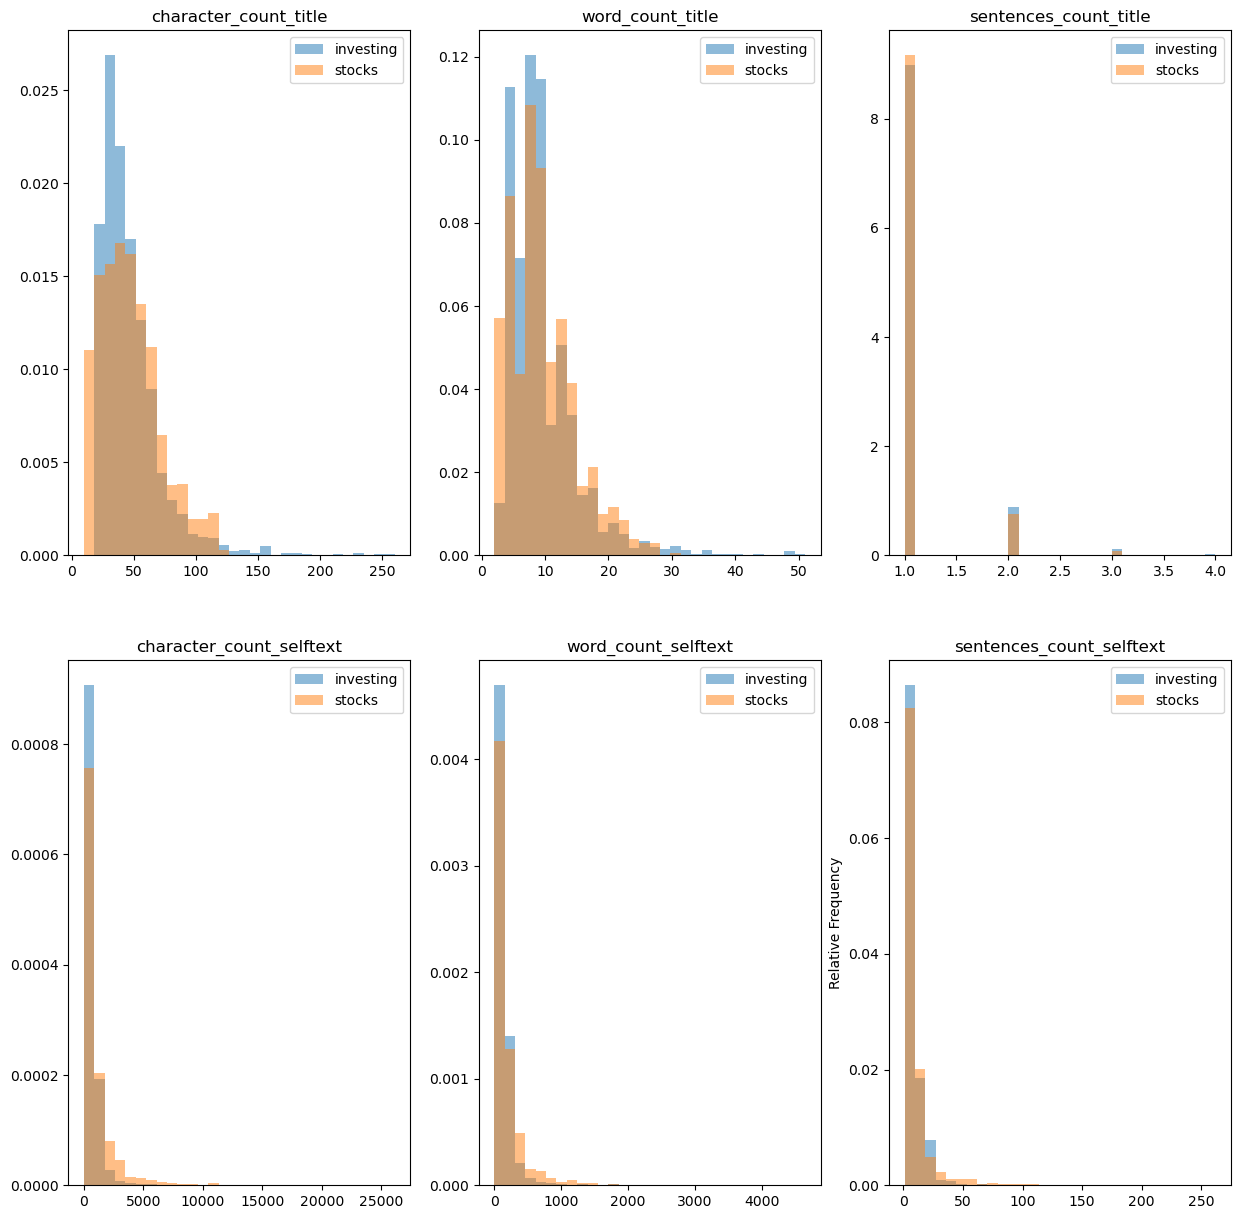

In [22]:
columns = ['character_count_title', 'word_count_title', 'sentences_count_title',
           'character_count_selftext', 'word_count_selftext', 'sentences_count_selftext']

subreddits = df_combined['subreddit'].unique()

# create a figure with multiple subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# iterate over the columns and create overlaid histograms for each column
for i, col in enumerate(columns):
    # calculate the bin edges for the current column
    data = df_combined[col]
    bins = np.histogram_bin_edges(data, bins=30)
    
    for subreddit in subreddits:
        # get the data for the current subreddit
        data = df_combined[df_combined['subreddit'] == subreddit][col]
        
        # create a histogram for the current subreddit using the calculated bin edges and set density=True
        axs[i // 3, i % 3].hist(data, bins=bins, alpha=0.5, label=subreddit, density=True)
    
    # set the title and add a legend
    axs[i // 3, i % 3].set_title(col)
    axs[i // 3, i % 3].legend()

plt.ylabel('Relative Frequency')
plt.show()

The body of submissions in r_stocks tend to have longer and more complex sentence structures as well as longer words than the body of submission in r_investing. The patterns among sentence and word structure with regard to titles of the two subreddits have less clear patterns. 

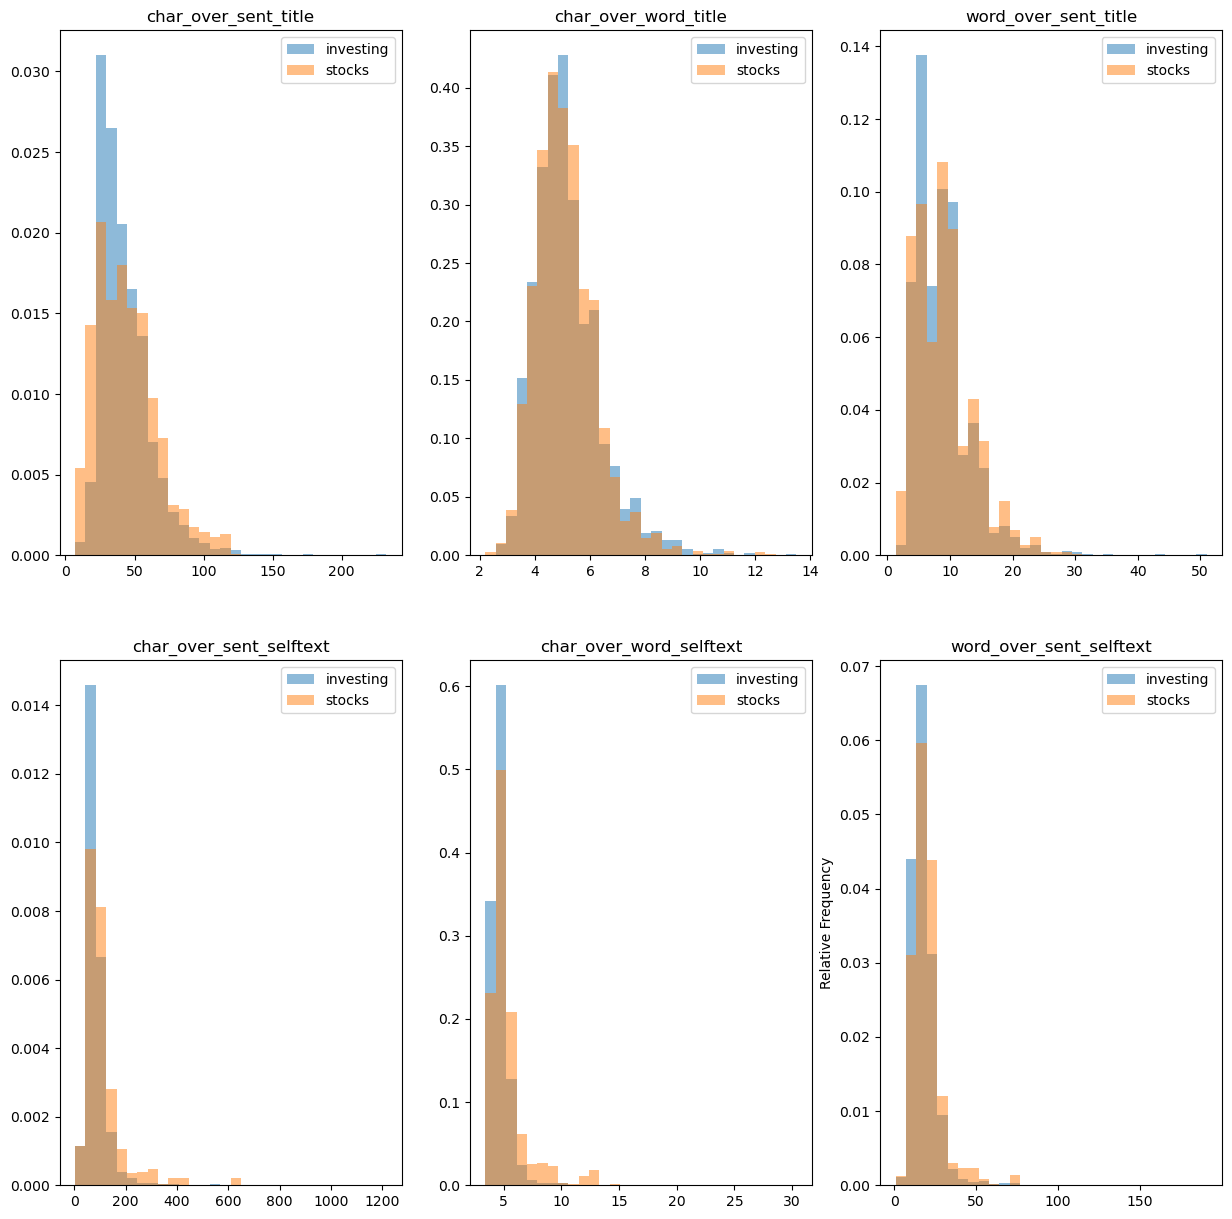

In [23]:
# define the columns for the histograms
columns = ['char_over_sent_title', 'char_over_word_title', 'word_over_sent_title',
           'char_over_sent_selftext', 'char_over_word_selftext', 'word_over_sent_selftext']

# get the unique values of the subreddit column
subreddits = df_combined['subreddit'].unique()

# create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# iterate over the columns and create overlaid histograms for each column
for i, col in enumerate(columns):
    # calculate the bin edges for the current column
    data = df_combined[col]
    bins = np.histogram_bin_edges(data, bins=30)
    
    for subreddit in subreddits:
        # get the data for the current subreddit
        data = df_combined[df_combined['subreddit'] == subreddit][col]
        
        # create a histogram for the current subreddit
        axs[i // 3, i % 3].hist(data, bins=bins, alpha=0.5, label=subreddit, density=True)
    
    # set title, add a legend
    axs[i // 3, i % 3].set_title(col)
    axs[i // 3, i % 3].legend()

plt.ylabel('Relative Frequency')
plt.show()

<font size="8">EDA: Selftext</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)

In [24]:
# define a function to count the number of sentences in a text
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [123]:
#create a new df with only the rows where subreddit is 'investing'
df_sentence_counter_investing = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_investing['sentence_count'] = df_combined['selftext'].apply(count_sentences)

#create a new df with only the rows where subreddit is 'stocks'
df_sentence_counter_stocks = df_combined[df_combined['subreddit'] == 'stocks']
#apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_stocks['sentence_count'] = df_stocks['selftext'].apply(count_sentences)

For the following two sections, EDA:Selftext and EDA:title the width of the bins of the first histogram in each document-length-metric (characters, words, sentences) will have uneven bin widths. 

Uneven bin widths:<br>
1. Allow for an easy understanding of where the frequencies of the given metric cross-over one another <br>
>Identify the cross-over points in the histogram will serve as the basis for the segmenting of the x-axis in the drill-down histograms that follow 
2. Allow for an easy understanding of the skew and kurtosis of the distribution

In [125]:
# plot a violin plot of the sentence counts for both subreddits in the first subplot
sns.violinplot(x="subreddit", y="sentences_count_selftext", data=df_sentence_counter_stocks[df_sentence_counter_stocks['sentences_count_selftext']>=0],
               ax=axs[0], cut=0)
sns.violinplot(x="subreddit", y="sentences_count_selftext", data=df_sentence_counter_investing[df_sentence_counter_investing['sentences_count_selftext']>=0],
               ax=axs[0], cut=0)

# add labels and legend to the first subplot
axs[0].set_xlabel('Subreddit')
axs[0].set_ylabel('Sentence Count')
axs[0].set_title('Sentence Counts, selftext')

Text(0.5, 1.0, 'Sentence Counts, selftext')

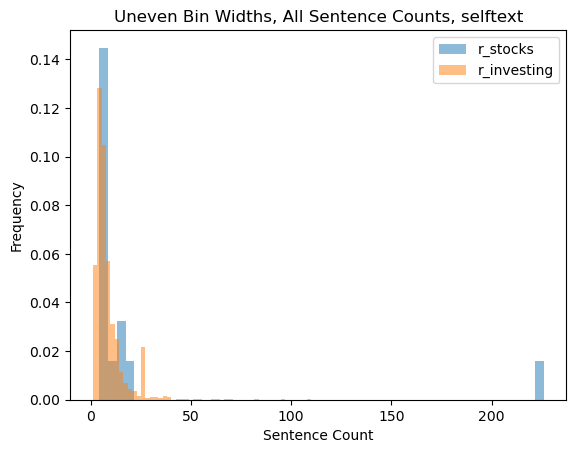

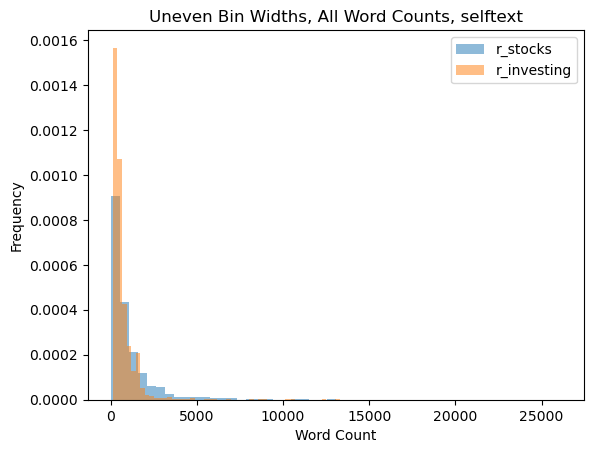

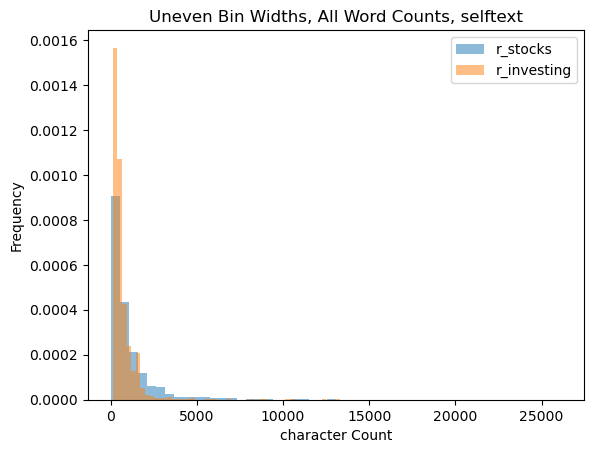

In [104]:
#plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=opacity, bins=50, label='r_stocks', density= True)

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=opacity, bins=50, label='r_investing', density= True)

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, selftext')
plt.legend()
plt.show()


# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['character_count_selftext'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['character_count_selftext'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_investing')

# add labels and legend
plt.xlabel('character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

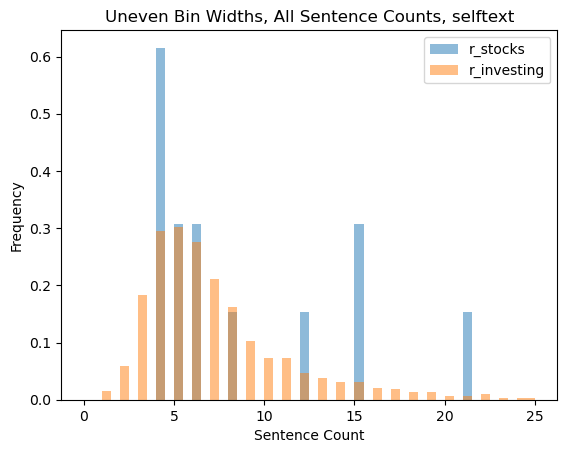

In [96]:
#plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=opacity, bins=50, range=(0,25), label='r_stocks', density= True)

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=opacity, bins=50, range=(0,25), label='r_investing', density= True)

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, selftext')
plt.legend()
plt.show()

/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


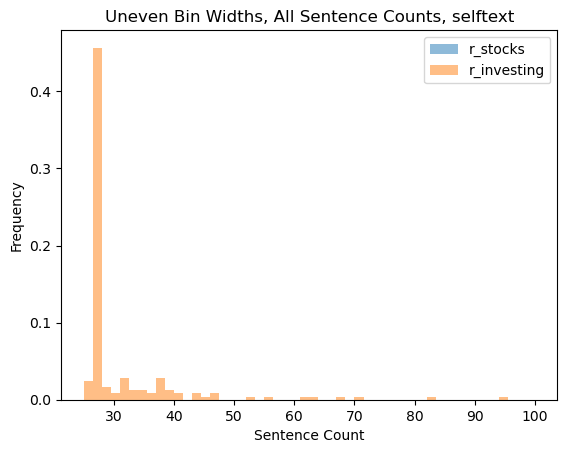

In [94]:
#plot a histogram of the sentence counts for stocks subreddit with custom opacity
opacity = 0.5
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=opacity, bins=50, range=(25,100), label='r_stocks', density= True)

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=opacity, bins=50, range=(25,100), label='r_investing', density= True)

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, selftext')
plt.legend()
plt.show()

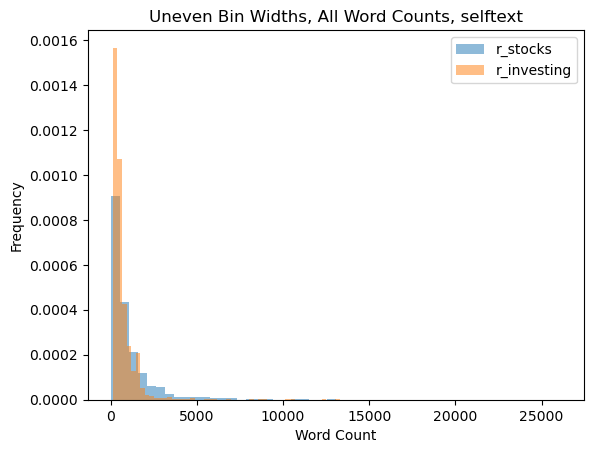

In [97]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=opacity, bins=50, density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

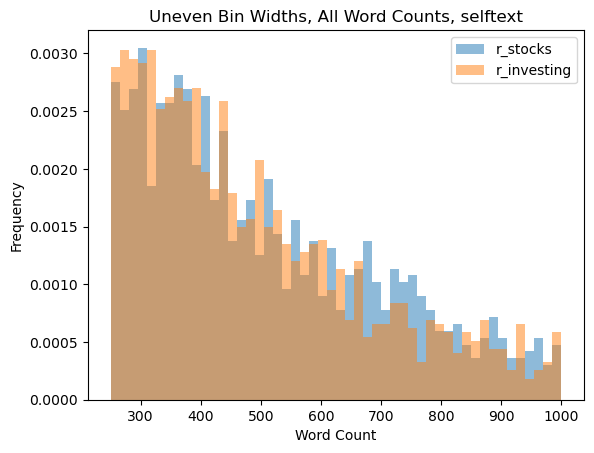

In [90]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=opacity, bins=50, range=(250,1000), density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=opacity, bins=50, range=(250,1000), density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

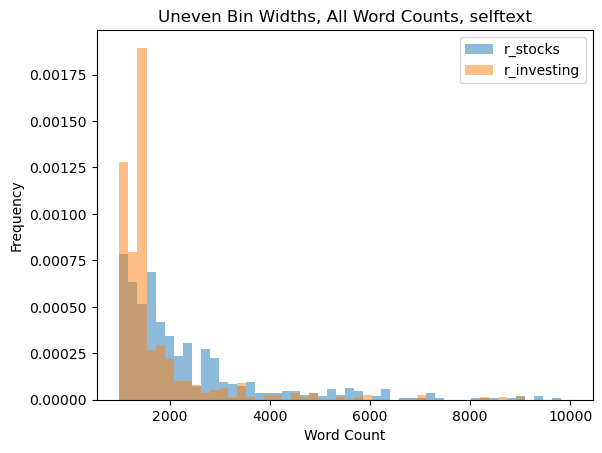

In [89]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=opacity, bins=50, range=(1000,10000), density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=opacity, bins=50, range=(1000,10000), density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

Investing acutally has more low sentence submissions, as the graphs below will illustrate. It is mandatory to add together all the r_investing bins enveloped by each r_stocks bin. r_stock bins tend to have longer sentences. When the width of the bins are set separately for r_stocks versus r_investing, it is clear that r_stocks has more long sentence posts than r_investing.

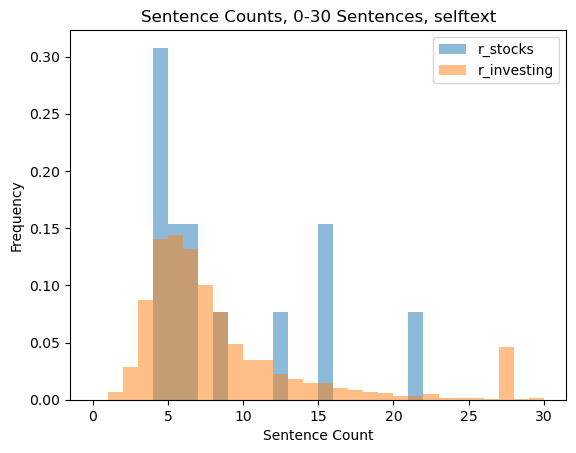

In [27]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=opacity, bins=30, range=(0,30),density= True, 
                                                       label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=opacity, bins=30, range=(0,30), 
                                                          density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sentence Counts, 0-30 Sentences, selftext')
plt.show()

In [28]:
# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks_selftext = df_combined[df_combined['subreddit'] == 'stocks']
df_character_counter_stocks_selftext['character_count'] = df_character_counter_stocks_selftext['selftext'].apply(count_characters)

# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing_selftext = df_combined[df_combined['subreddit'] == 'investing']
df_character_counter_investing_selftext['character_count'] = df_character_counter_investing_selftext['selftext'].apply(count_characters)

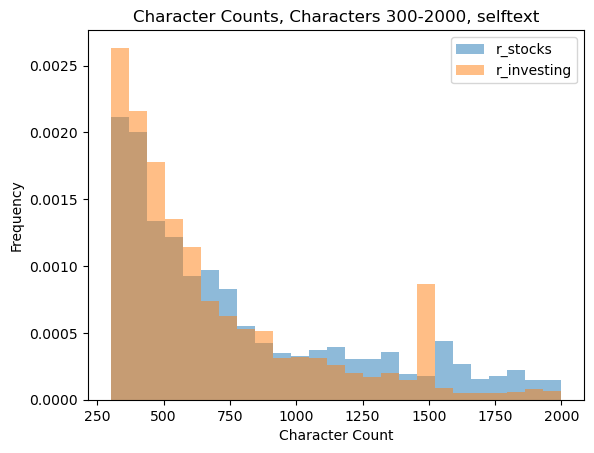

In [31]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=opacity, bins=25, range=(300,2000),
                                                                  density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=opacity, bins=25, range=(300,2000),
                                                                     density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, Characters 300-2000, selftext')
plt.legend()
plt.show()

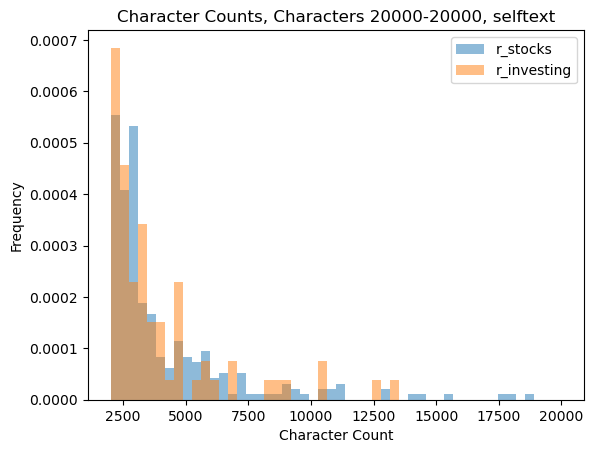

In [32]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=opacity, bins=50, range=(2000,20000), 
                                                                  density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=opacity, bins=50, range=(2000,20000), 
                                                                     density= True, label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, Characters 20000-20000, selftext')
plt.legend()
plt.show()

<font size="4">EDA: selftext: words</font>


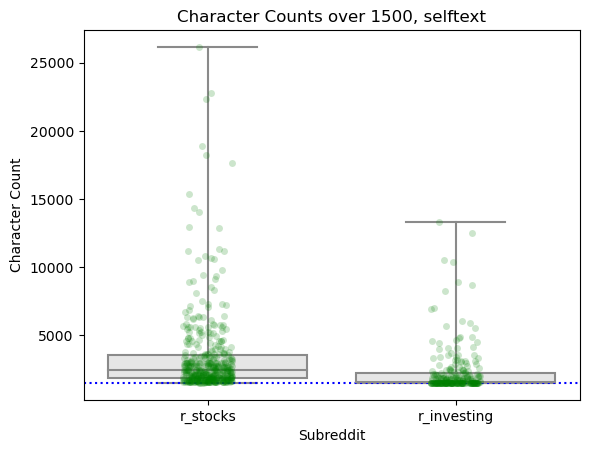

In [87]:
# create a new dataframe for the plot
df = pd.concat([df_character_counter_stocks_selftext[['character_count']].assign(dataset='r_stocks'), 
                df_character_counter_investing_selftext[['character_count']].assign(dataset='r_investing')])

# exclude all values below 1000
df = df[df['character_count'] >= 1500]

# plot a strip plot of the character counts for both subreddits
sns.stripplot(x="dataset", y="character_count", alpha= 0.2, color='green', data=df)

# overlay a box and whisker plot onto the strip plot
sns.boxplot(x="dataset", y="character_count", data=df, whis=np.inf, color=".9")

# draw a dotted yellow line at y=1500
plt.axhline(1500, color='blue', linestyle='dotted')

# add labels and title
plt.xlabel('Subreddit')
plt.ylabel('Character Count')
plt.title('Character Counts over 1500, selftext')
plt.show()

In [33]:
# create a new DataFrame with only the rows where subreddit is 'stocks'
df_word_counter_stocks_selftext = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_word_counter_stocks_selftext['word_count'] = df_character_counter_stocks_selftext['selftext'].apply(count_characters)

# create a new DataFrame with only the rows where subreddit is 'investing'
df_word_counter_investing_selftext = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_word_counter_investing_selftext['word_count'] = df_word_counter_investing_selftext['selftext'].apply(count_characters)

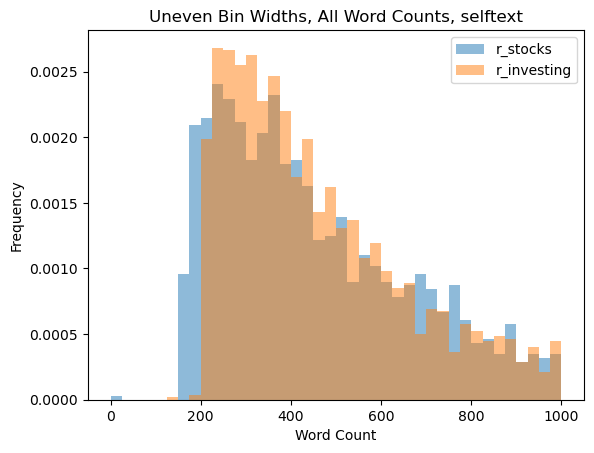

In [35]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=opacity, bins=40, range=(0,1000), density= True,  
                                                        label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=opacity, bins=40, range=(0,1000), density= True,  
                                                           label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

<font size="8">EDA: title</font>
<a id='destination_cell_12'></a>

[Return to Table of Contents](#destination_cell_10)

<font size="4">EDA: title: Sentences</font>

In [37]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_investing['character_count'] = df_character_counter_investing['title'].apply(count_characters)

# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_stocks['character_count'] = df_character_counter_stocks['title'].apply(count_characters)

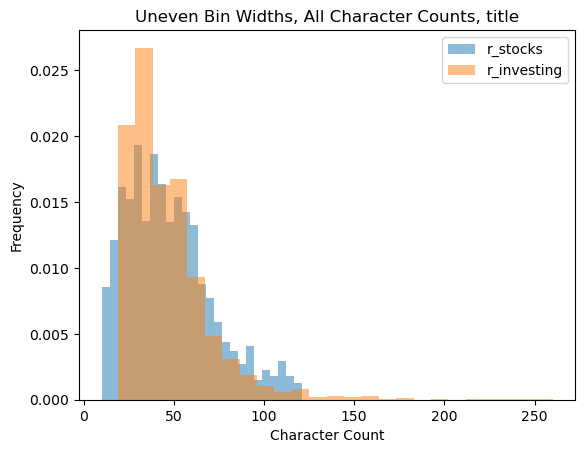

In [38]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks['character_count'].plot.hist(alpha=opacity, bins=25, density= True,  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing['character_count'].plot.hist(alpha=opacity, bins=25, density= True,  label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Character Counts, title')
plt.legend()
plt.show()

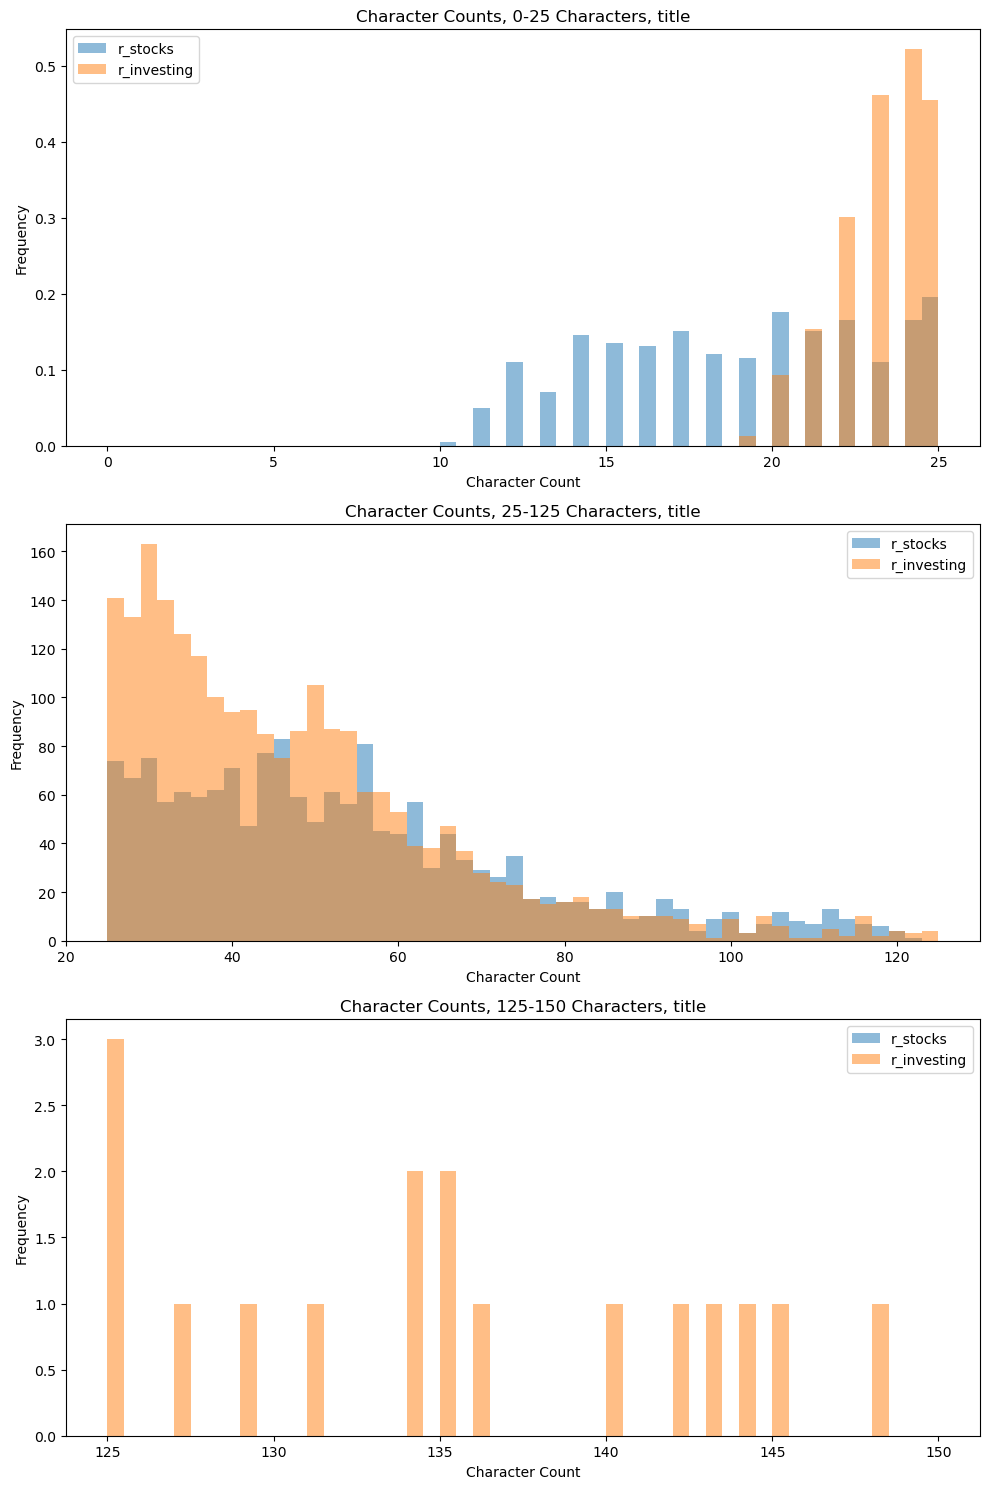

In [88]:
# create a figure with 3 subplots
fig, axs = plt.subplots(3, figsize=(10,15))

# plot a histogram of the character counts for both subreddits in the first subplot
df_character_counter_stocks['character_count'].plot.hist(alpha=opacity, bins=50, range=(0,25), density=True, ax=axs[0], label='r_stocks')
df_character_counter_investing['character_count'].plot.hist(alpha=opacity, bins=50, range=(0,25), density=True, ax=axs[0], label='r_investing')

# add labels and legend to subplot #1
axs[0].set_xlabel('Character Count')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Character Counts, 0-25 Characters, title')
axs[0].legend()

# plot a histogram of the character counts for both subreddits in the second subplot
df_character_counter_stocks['character_count'].plot.hist(alpha=opacity, bins=50, range=(25,125), ax=axs[1], label='r_stocks')
df_character_counter_investing['character_count'].plot.hist(alpha=opacity, bins=50, range=(25,125), ax=axs[1], label='r_investing')

# add labels and legend to subplot #2
axs[1].set_xlabel('Character Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Character Counts, 25-125 Characters, title')
axs[1].legend()

# plot a histogram of the character counts for both subreddits in the third subplot
df_character_counter_stocks['character_count'].plot.hist(alpha=opacity, bins=50, range=(125,150), ax=axs[2], label='r_stocks')
df_character_counter_investing['character_count'].plot.hist(alpha=opacity, bins=50, range=(125,150), ax=axs[2], label='r_investing')

# add labels and legend to subplot #3
axs[2].set_xlabel('Character Count')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Character Counts, 125-150 Characters, title')
axs[2].legend()

# display the figure with subplots
plt.tight_layout()
plt.show()

<font size="4">EDA: title: Sentences</font>

In [42]:
# define a function to count the number of sentences in a text, same functions as used in EDA: selftext
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [43]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_sentence_counter_investing_title = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_investing_title['sentence_count'] = df_combined['title'].apply(count_sentences)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_sentence_counter_stocks_title = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_stocks_title['sentence_count'] = df_stocks['title'].apply(count_sentences)


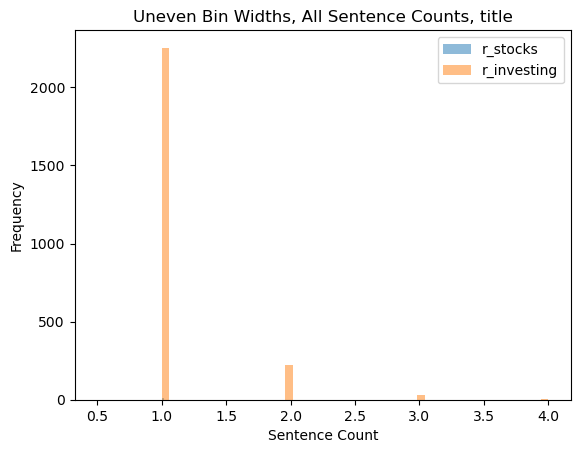

In [44]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks_title['sentence_count'].plot.hist(alpha=opacity, bins=50, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing_title['sentence_count'].plot.hist(alpha=opacity, bins=50, label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, title')
plt.legend()
plt.show()

In [45]:
def count_characters(text):
    # remove whitespace characters
    text = text.replace(' ', '').replace('\n', '').replace('\t', '')
    # return the length of the text
    return len(text)

In [46]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing_title = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_investing_title['character_count'] = df_character_counter_investing_title['title'].apply(count_characters)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks_title = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_stocks_title['character_count'] = df_character_counter_stocks_title['title'].apply(count_characters)


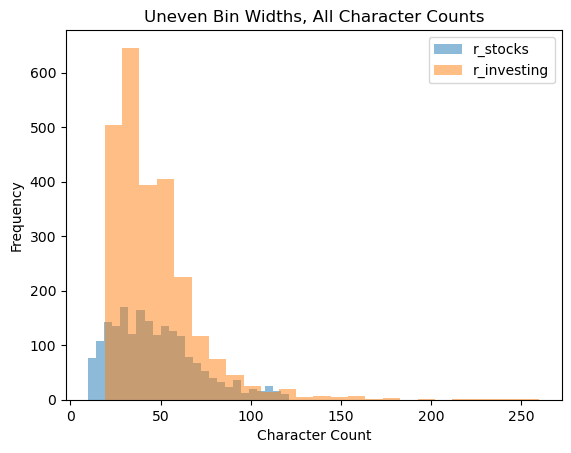

In [47]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_title['character_count'].plot.hist(alpha=opacity, bins=25, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_title['character_count'].plot.hist(alpha=opacity, bins=25, label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Character Counts')
plt.legend()
plt.show()

<font size="8">EDA: Non-text Features</font>
<a id='destination_cell_8'></a>

[Return to Table of Contents](#destination_cell_10)

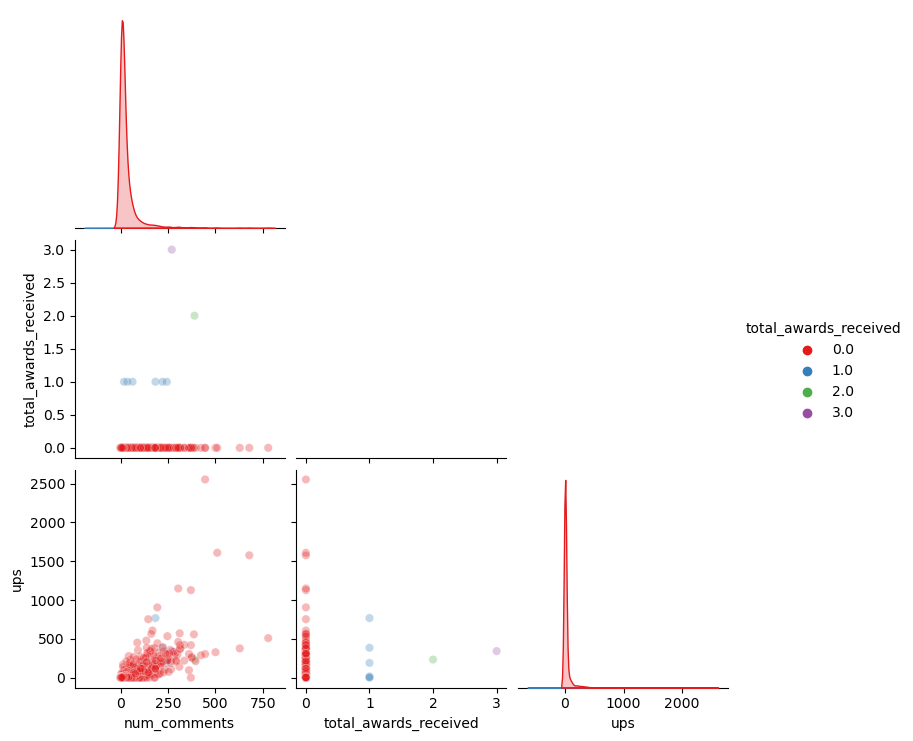

In [48]:
pairplot_columns = df_investing[['num_comments', 'total_awards_received', 'ups']]
sns.pairplot(df_investing, vars=pairplot_columns, hue='total_awards_received', plot_kws={'alpha': 0.3}, 
             corner=True, palette='Set1');

There is a clear difference in the relationship between number of comments and upvote between the two subreddits.

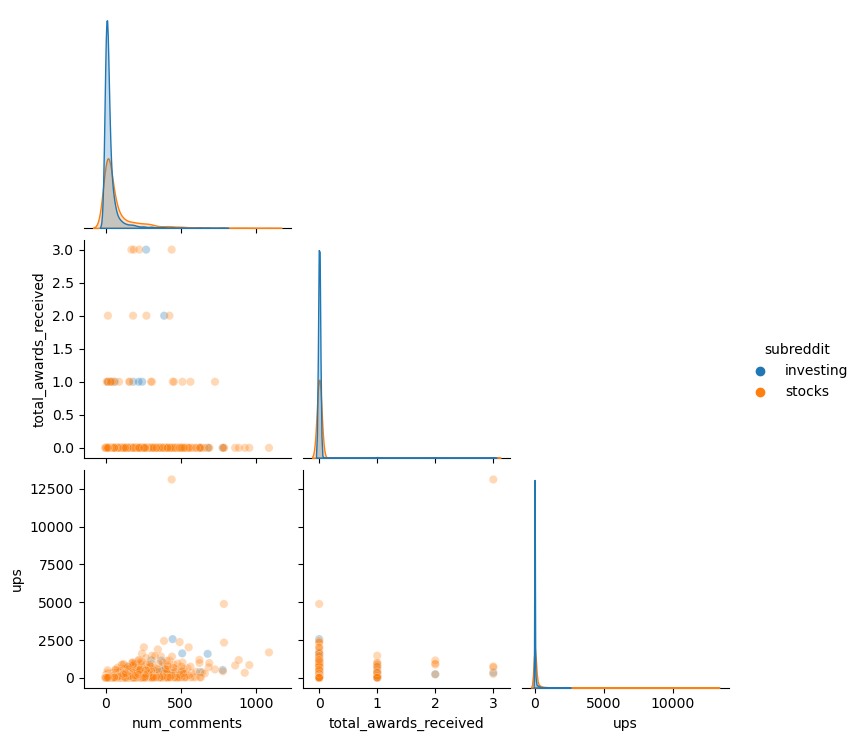

In [50]:
# Select the columns to include in the pairplot
pairplot_columns = ['num_comments', 'total_awards_received', 'ups']

#concatenate the two dataframes
df_combined_2 = pd.concat([df_investing, df_stocks], ignore_index=True)

#create a pairplot of the combined dataframe, coloring the observations according to the "dataframe" column
sns.pairplot(df_combined_2, vars=pairplot_columns, hue='subreddit', plot_kws= {'alpha':0.3}, corner= True);

As you can see there is a strong correltaion between upvotes and number of comments in the investment subreddit, but a far weaker correlation between upvotes and number of comments in the r_stocks <br>

Since we see more orange (stocks) in the histogram above blues (investing) in the histogram, we can conclude that the term frequencies of individual terms as a percentage of all terms is higher for the terms that belong to r_stocks than it is for the terms that belong to r_investing. r_investing term frequencies has a lower kurtosis than r_stocks <br>

This will calculate the term frequency: (Tfidvecrotizer (use_idf=flase))  within the context of a larger corpus, aka pass many documents into my TFIDVectorizer, and then I want the funciton to calculate a document-specific score based on how the (Tfidvecrotizer (use_idf=flase))  scores of the terms of the inputted document map to the distribution of (Tfidvecrotizer (use_idf=flase)) scores of the corpus. <br>


In [51]:
def tf_avg(document, corpus):
    #create a TfidfVectorizer object with use_idf=False
    vectorizer = TfidfVectorizer(use_idf=False)
    
    #fit the vectorizer on the corpus
    X = vectorizer.fit_transform(corpus)
    
    #transform the input document
    doc_vec = vectorizer.transform([document])
    
    #get the term frequency array for the input document
    tf_array = doc_vec.toarray()[0]
    
    #calculate the sum of term frequencies
    tf_sum = tf_array.sum()
    
    #calculate the total number of terms in the input document
    num_terms = len(document.split())
    
    return tf_sum / num_terms

In [ ]:
#create a corpus for the 'selftext' and 'title' columns
corpus_selftext = df_combined['selftext'].tolist()
corpus_title = df_combined['title'].tolist()

#create empty lists to store the average term frequencies
avg_tfs_selftext = []
avg_tfs_title = []

#loop over the rows of your dataframe
for idx, row in df_combined.iterrows():
    #get the document for the current row
    document_selftext = row['selftext']
    document_title = row['title']
    
    #calculate the average term frequency
    avg_tf_selftext = tf_avg(document_selftext, corpus_selftext)
    avg_tf_title = tf_avg(document_title, corpus_title)
    
    #append the result to the list
    avg_tfs_selftext.append(avg_tf_selftext)
    avg_tfs_title.append(avg_tf_title)

#create new columns in your dataframe with the average term frequencies
df_combined['avg_term_frequency_selftext'] = avg_tfs_selftext
df_combined['avg_term_frequency_title'] = avg_tfs_title

In [ ]:
#save the df to a CSV file
df_combined.to_csv('/Users/nicholassanso/Desktop/GA/projects/project-3/post_grad_p3/df_combined.csv', index=False)